In [8]:
using LinearAlgebra, Symbolics, Combinatorics, Plots, PlotThemes, LaTeXStrings, PrettyTables
theme(:dao)

# Derivation of CoM Relation

In [12]:
@variables m1 m2 m3 x1 x2 x3 y1 y2 y3 z1 z2 z3

masses_sym = [m1, m2, m3]
positions_sym = [
    x1 y1 z1
    x2 y2 z2
    x3 y3 z3
];

In [13]:
pos_mas_sym = positions_sym .* masses_sym

3×3 Matrix{Num}:
 m1*x1  m1*y1  m1*z1
 m2*x2  m2*y2  m2*z2
 m3*x3  m3*y3  m3*z3

In [14]:
com_x_sym = sum(pos_mas_sym[1:end, 1]) / sum(masses_sym)

(m1*x1 + m2*x2 + m3*x3) / (m1 + m2 + m3)

In [15]:
com_pos_sym = [sum(pos_mas_sym[1:end, i]) / sum(masses_sym) for i ∈ 1:3]

3-element Vector{Num}:
 (m1*x1 + m2*x2 + m3*x3) / (m1 + m2 + m3)
 (m1*y1 + m2*y2 + m3*y3) / (m1 + m2 + m3)
 (m1*z1 + m2*z2 + m3*z3) / (m1 + m2 + m3)

# Eigenvalue/Eigenvector Problem

In [4]:
@variables J₁₁, J₁₂, J₁₃, J₂₁, J₂₂, J₂₃, J₃₁, J₃₂, J₃₃, λ₁, λ₂, λ₃, e₁, e₂, e₃;

In [5]:
J = [
    J₁₁ J₁₂ J₁₃
    J₂₁ J₂₂ J₂₃
    J₃₁ J₃₂ J₃₃
]

λ = [λ₁, λ₂, λ₃]

e = [e₁, e₂, e₃];

In [11]:
λ[1] * I(3) - J

3×3 Matrix{Num}:
 λ₁ - J₁₁      -J₁₂      -J₁₃
     -J₂₁  λ₁ - J₂₂      -J₂₃
     -J₃₁      -J₃₂  λ₁ - J₃₃

# $k$ Values of Mass Permutations

In [10]:
corner_positions = [
             0         0         0
    2.9000         0         0
    2.9000    1.8500         0
         0    1.8500         0
         0         0    2.1500
    2.9000         0    2.1500
    2.9000    1.8500    2.1500
         0    1.8500    2.1500
];

In [11]:
masses = [8, 1, 2, 8, 4, 1, 8, 7]

# function to get coordinates of CoM
function center_of_mass(positions, masses)
    pos_mas_matrix = positions .* masses
    com_pos = [sum(pos_mas_matrix[1:end, i]) / sum(masses) for i ∈ 1:3]
    
    return com_pos
end

# function to get mean deviation from center of yz plane
function yz_mean_deviation(y, z; y_c = 0.925, z_c = 1.075)
    Δy = abs(y - y_c)
    Δz = abs(z - z_c)
    
    mean_deviation = (Δy + Δz) / 2
    
    return mean_deviation    
end

function cross_mat(vector)
    @assert length(vector) == 3 "Vectors of length 3 required"
    return [
        0 -vector[3] vector[2]
        vector[3] 0 -vector[1]
        -vector[2] vector[1] 0
    ]
end

# generating permutations of mass combinations
perms = unique(permutations(masses));

In [12]:
function get_k_vals(mass_positions, masses; rotation=nothing)
    com = center_of_mass(mass_positions, masses)
    pos_com = mass_positions .- transpose(com)
    
    Jb = -sum([
        masses[i] * cross_mat(pos_com[i, 1:end]) * cross_mat(pos_com[i, 1:end]) for i ∈ 1:size(pos_com, 1)
    ])
    
    Jb_p = eigvals(Jb)
    
    if rotation != nothing
        Jb_p  = rotation * Jb_p
    end
    
    J1, J2, J3 = Jb_p
    k1 = (J2 - J3) / J1
    k2 = (J1 - J3) / J2
    k3 = (J2 - J1) / J3
    
    return k1, k2, k3
end

get_k_vals (generic function with 1 method)

In [13]:
k_vals_orig = [get_k_vals(corner_positions, perm) for perm in perms]
k1_vec_orig = [k[1] for k in k_vals_orig]
k3_vec_orig = [k[3] for k in k_vals_orig]

k_vals_rot = [get_k_vals(corner_positions, perm, rotation=[0 1 0; 0 0 1; 1 0 0]) for perm in perms]
k1_vec_rot = [k[1] for k in k_vals_rot]
k2_vec_rot = [k[2] for k in k_vals_rot]
k3_vec_rot = [k[3] for k in k_vals_rot];

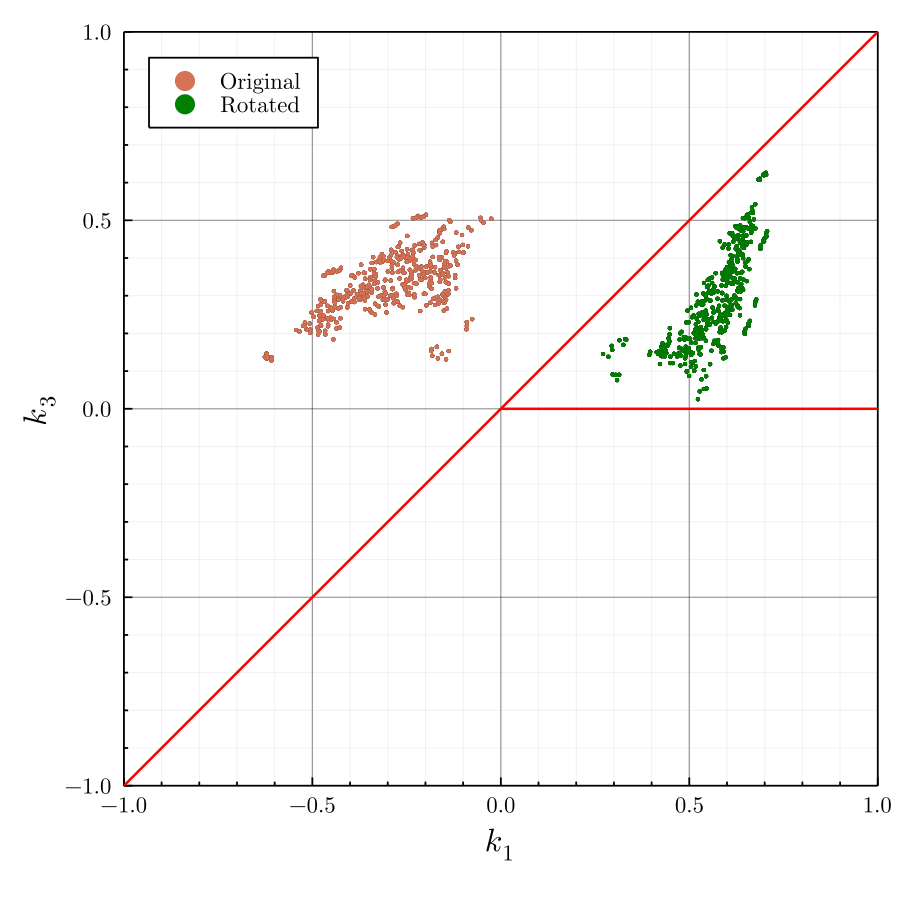

In [17]:
scatter(
    k1_vec_orig,
    k3_vec_orig,
    xlim=(-1,1),
    ylim=(-1,1),
    label="Original",
    size=(500,500),
    markersize=1.5,
    aspect_ratio=:equal,
    legend=:topleft,
    xlabel=L"k_1",
    ylabel=L"k_3",
    fmt=:png,
    dpi=180
)

scatter!(k1_vec_rot, k3_vec_rot, label="Rotated", markersize=1.5, color=:green)

plot!([-1, 1], [-1, 1], label="", color=:red)
plot!([0, 1], [0, 0], label="", color=:red)

In [18]:
case1_rotation = [
    0 1 0
    0 0 1
    1 0 0
]

3×3 Matrix{Int64}:
 0  1  0
 0  0  1
 1  0  0

In [19]:
function check_stability(k1, k3)
    cond1 = k1*k3 > 0
    cond2 = 1 + 3*k1 + k1*k3 > 0
    cond3 = (1 + 3*k1 + k1*k3)^2 - 16*k1*k3 > 0
    
    if cond1 && cond2 && cond3
        return true
    else
        return false
    end
end

check_stability (generic function with 1 method)

In [20]:
coms = [center_of_mass(corner_positions, perm) for perm in perms]

# finding deviations of CoM positions from center of yz plane
deviations = [yz_mean_deviation(com[2], com[3]) for com in coms];

min_deviation = minimum(deviations)

0.025641025641025605

In [21]:
function get_frequences(k1, k2, k3, n)
    ω_pitch = sqrt(3 * abs(k2)) * n
    
    b = k1*k3 + 3*k1 + 1
    c = 4*k1*k3
    ω_roll = sqrt(0.5*(b + sqrt(b^2 - 4*c)))
    ω_yaw = sqrt(0.5*(b - sqrt(b^2 - 4*c)))
    
    return ω_pitch, ω_roll, ω_yaw
end

get_frequences (generic function with 1 method)

In [22]:
period = 105
n = 2*π / period

0.059839860068377014

In [23]:
results = []
for i in 1:length(perms)
    if deviations[i] <= min_deviation
        perm = perms[i]
        stability = check_stability(k1_vec_rot[i], k3_vec_rot[i])
        ω_p, ω_r, ω_y = get_frequences(k1_vec_rot[i], k2_vec_rot[i], k3_vec_rot[i], n)
        mean_oscillation = (ω_p + ω_r + ω_y)/3
        
        #println("$i \t $perm \t $stability \t $(round(ω_p, digits=3)) \t $(round(ω_r, digits=3)) \t $(round(ω_y, digits=3)) \t $(round(mean_oscillation, digits=3))")
        push!(results, [i, stability, ω_p, ω_r, ω_y, mean_oscillation])
    end
end

In [24]:
pretty_table(
    reduce(hcat, results)',
    header=["Index", "Stability", "ω_pitch", "ω_roll", "ω_yaw", "ω_mean"]
)

┌────────┬───────────┬───────────┬─────────┬──────────┬──────────┐
│  Index │ Stability │   ω_pitch │  ω_roll │    ω_yaw │   ω_mean │
├────────┼───────────┼───────────┼─────────┼──────────┼──────────┤
│    6.0 │       1.0 │ 0.0722969 │ 1.71953 │ 0.505122 │ 0.765649 │
│   20.0 │       1.0 │  0.065977 │ 1.68134 │ 0.529625 │  0.75898 │
│   66.0 │       1.0 │ 0.0611758 │ 1.68607 │ 0.594574 │ 0.780605 │
│   80.0 │       1.0 │ 0.0622046 │ 1.73325 │ 0.656853 │ 0.817436 │
│ 1266.0 │       1.0 │ 0.0614762 │ 1.53554 │ 0.331729 │ 0.642916 │
│ 1280.0 │       1.0 │ 0.0557251 │ 1.49545 │ 0.352476 │  0.63455 │
│ 1326.0 │       1.0 │ 0.0405751 │ 1.34466 │ 0.295186 │ 0.560139 │
│ 1340.0 │       1.0 │ 0.0600699 │  1.5264 │ 0.339232 │ 0.641902 │
└────────┴───────────┴───────────┴─────────┴──────────┴──────────┘


# Derivation of Rotational Kinetic Energy Equation

In [2]:
@variables ω₁, ω₂, ω₃, J₁, J₂, J₃
ω = [ω₁, ω₂, ω₃]
J = [J₁, J₂, J₃]

3-element Vector{Num}:
 J₁
 J₂
 J₃

In [6]:
T = 0.5 * ω' * J * ω

3-element Vector{Num}:
 ω₁*(0.5J₁*ω₁ + 0.5J₂*ω₂ + 0.5J₃*ω₃)
 ω₂*(0.5J₁*ω₁ + 0.5J₂*ω₂ + 0.5J₃*ω₃)
 ω₃*(0.5J₁*ω₁ + 0.5J₂*ω₂ + 0.5J₃*ω₃)